# NST with Pytorch

In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import os
import glob
import random
import copy
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# for google colab
# copy all files from "ML/Neural_Style_Transfer" directory in Google drive to current directory
!cp -r ./gdrive/MyDrive/Neural_Style_Transfer/* .

In [3]:
# This detect if cuda is available for GPU training otherwise it will use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu
print(imsize)

cuda
512


In [4]:
# Helper function
def image_loader(image_name):
    # scale imported image
    # transform it into a torch tensor
    loader = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

# Helper function to show the tensor as a PIL image
def imshow(tensor, title=None):
    unloader = transforms.ToPILImage()  # reconvert into PIL image
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

In [5]:
# Loading images
image_directory = "images/"
# style_img = image_loader(image_directory + "picasso.jpg")
# content_img = image_loader(image_directory + "dancing.jpg")
# loader = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])
# style_img = Image.open(image_directory + "style.png").convert('RGB')
# style_img = style_img.resize((512, 512))
# print(style_img.size)
# # fake batch dimension required to fit network's input dimensions
# style_img = loader(style_img).unsqueeze(0)
# style_img = style_img.to(device, torch.float)

# loader = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])
# content_img = Image.open(image_directory + "content.png").convert('RGB')
# content_img = content_img.resize((512, 512))
# # fake batch dimension required to fit network's input dimensions
# content_img = loader(content_img).unsqueeze(0)
# content_img = content_img.to(device, torch.float)

content_imgs = []
style_imgs = []
for i in range(16):
  content_img = Image.open(image_directory + "content_image/{i}.png".format(i=i)).convert('RGB')
  orig_color = (0,0,0)
  replacement_color = (255,255,255)
  data = np.array(content_img)
  data[(data == orig_color).all(axis = -1)] = replacement_color
  content_img = Image.fromarray(data, mode='RGB')
  content_imgs.append(content_img)

stacked_content_img = np.vstack((np.hstack((content_imgs[0:4])),np.hstack((content_imgs[4:8])),np.hstack((content_imgs[8:12])),np.hstack((content_imgs[12:16]))))
stacked_content_img = Image.fromarray(np.uint8(stacked_content_img)).convert('RGB')
loader = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])
stacked_content_img = loader(stacked_content_img).unsqueeze(0)
stacked_content_img = stacked_content_img.to(device, torch.float)

for f in enumerate(random.sample(glob.glob(image_directory + "style_image/B/*.png"), 16), 1):
  style_img = Image.open(f[1]).convert('RGB')
  orig_color = (0,0,0)
  replacement_color = (255,255,255)
  data = np.array(style_img)
  data[(data == orig_color).all(axis = -1)] = replacement_color
  style_img = Image.fromarray(data, mode='RGB')
  style_imgs.append(style_img)

stacked_style_img = np.vstack((np.hstack((style_imgs[0:4])),np.hstack((style_imgs[4:8])),np.hstack((style_imgs[8:12])),np.hstack((style_imgs[12:16]))))
stacked_style_img = Image.fromarray(np.uint8(stacked_style_img)).convert('RGB')
loader = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])
stacked_style_img = loader(stacked_style_img).unsqueeze(0)
stacked_style_img = stacked_style_img.to(device, torch.float)


# style_img = image_loader(image_directory + "B/style_image/9.png")
# content_img = image_loader(image_directory + "content_image/9.png")

# assert style_img.size() == content_img.size(), "we need to import style and content images of the same size"

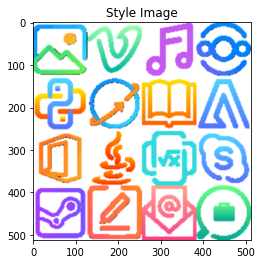

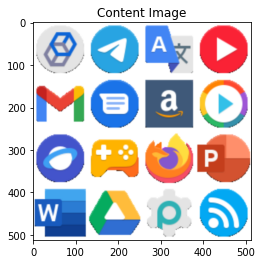

In [6]:
plt.ion()
# Show style image
plt.figure()
imshow(stacked_style_img, title='Style Image')
# Show content image
plt.figure()
imshow(stacked_content_img, title='Content Image')

In [7]:
# Importing the VGG 19 model like in the paper (here we set it to evaluation mode)
cnn = models.vgg19(pretrained=True).features.to(device).eval()
# cnn = models.vgg16(pretrained=True).features.to(device).eval()
# cnn = models.vgg13(pretrained=True).features.to(device).eval()
# cnn = models.vgg19_bn(pretrained=True).features.to(device).eval()
# cnn = models.vgg16_bn(pretrained=True).features.to(device).eval()
# cnn = models.vgg13_bn(pretrained=True).features.to(device).eval()

# VGG network are normalized with special values for the mean and std
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [8]:
# Hyperparameters
num_steps = 300
default_num_steps = 300
default_style_weight = 1000000
default_content_weight = 1

In [9]:
# Custom content loss
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [10]:
# This is for the style loss
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

# Same structure as the content loss
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [11]:
# create a module to normalize input image so we can easily put it in a nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [12]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

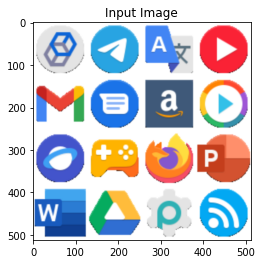

In [13]:
input_img = stacked_content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

# This type of optimizer was prefered by the author of the paper
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [14]:
# This will run the neural style transfer
# It will create image that goes above 1 or below 0, however it will be normalized
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=default_num_steps,
                       style_weight=default_style_weight, content_weight=default_content_weight):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction to have the tensors between 0 and 1
    input_img.data.clamp_(0, 1)

    return input_img

Building the style transfer model..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


Optimizing..
run [50]:
Style Loss : 467.345947 Content Loss: 10.668190

run [100]:
Style Loss : 165.119965 Content Loss: 13.459133

run [150]:
Style Loss : 155.434967 Content Loss: 17.213676

run [200]:
Style Loss : 125.804581 Content Loss: 19.159241

run [250]:
Style Loss : 895.615173 Content Loss: 20.869492

run [300]:
Style Loss : 169.206909 Content Loss: 26.065182

run [350]:
Style Loss : 3057.581055 Content Loss: 28.292412

run [400]:
Style Loss : 10137205.000000 Content Loss: 340.810883

run [450]:
Style Loss : 3643.536377 Content Loss: 44.147804

run [500]:
Style Loss : 997.955811 Content Loss: 37.623249

run [550]:
Style Loss : 475.671783 Content Loss: 34.732838

run [600]:
Style Loss : 254.408691 Content Loss: 33.040932

run [650]:
Style Loss : 144.602310 Content Loss: 31.927059

run [700]:
Style Loss : 8007.785156 Content Loss: 36.037296

run [750]:
Style Loss : 80.239342 Content Loss: 31.190437

run [800]:
Style Loss : 2434.322266 Content Loss: 36.172844

run [850]:
Style Lo

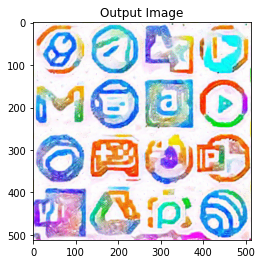

In [15]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            stacked_content_img, stacked_style_img, input_img, 1500)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [16]:
from numpy import cov
from numpy import asarray
from scipy.linalg import sqrtm
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from skimage.transform import resize
from numpy import trace
from numpy import iscomplexobj

In [17]:
# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)

# calculate frechet inception distance
def calculate_fid(model, images1, images2):
    # calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# prepare the inception v3 model
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

87924736/87910968 [==============================] - 0s 0us/step


In [18]:
def split_images(tensor):
  unloader = transforms.ToPILImage()  # reconvert into PIL image
  image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
  image = image.squeeze(0)      # remove the fake batch dimension
  image = unloader(image)
  image = np.array(image)
  M = imsize//4
  N = imsize//4
  imgs = [image[x:x+M,y:y+N] for x in range(0,imsize,M) for y in range(0,imsize,N)]
  return imgs

In [19]:
fids = []
imgs = split_images(stacked_content_img)
predictions = split_images(output)

imgs = np.asarray(imgs)
predictions = np.asarray(predictions)
# convert integer to floating point values
imgs = imgs.astype('float32')
predictions = predictions.astype('float32')
# resize images
imgs = scale_images(imgs, (299, 299, 3))
predictions = scale_images(predictions, (299, 299, 3))
# pre-process images
imgs = preprocess_input(imgs)
predictions = preprocess_input(predictions)
# calculate fid
fid = calculate_fid(inception_model, imgs, predictions)
fids.append(fid)
print(f"FID: {fid}")

FID: 354.37262481681404


In [20]:
for fid in fids:
  print(fid)

354.37262481681404
